# Tugas 1

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tabulate import tabulate
import numpy as np

# ---------------------------------------------------------------------------
# BAGIAN 1: KLASIFIKASI SVM PADA DATA 'voice.csv'
# ---------------------------------------------------------------------------

print("--- Memulai Bagian 1: Analisis data voice.csv ---")

# --- 1. Memuat dan Mempersiapkan Data ---

# Memuat dataset
try:
    df = pd.read_csv('voice.csv')
    print("Dataset 'voice.csv' berhasil dimuat.")
except FileNotFoundError:
    print("Error: File 'voice.csv' tidak ditemukan.")
    # Keluar jika file tidak ada
    exit()

# Memisahkan fitur (X) dan target (y)
X = df.drop('label', axis=1)
y = df['label']

# Encoding label target (misal: 'male' -> 1, 'female' -> 0)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Label target telah di-encode: {le.classes_}")

# Penskalaan Fitur (Sangat penting untuk SVM)
# SVM sensitif terhadap skala fitur, jadi kita gunakan StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Fitur telah diskalakan menggunakan StandardScaler.")

# --- 2. Mendefinisikan Model dan Skenario Uji ---

# Skenario split data (rasio test)
split_ratios = [0.3, 0.2]  # Ini merepresentasikan 70:30 dan 80:20
# Kernel SVM yang akan diuji
kernels = ['linear', 'poly', 'rbf']

# List untuk menyimpan hasil
results = []

# --- 3. Melatih dan Mengevaluasi Model ---

print("\nMemulai pelatihan model untuk setiap skenario...")

# Looping untuk setiap rasio split
for test_size in split_ratios:
    train_ratio = int((1 - test_size) * 100)
    test_ratio = int(test_size * 100)
    split_name = f"{train_ratio}:{test_ratio}"

    print(f"\n-- Menguji Split Rasio: {split_name} --")

    # Membagi data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=test_size, random_state=42, stratify=y_encoded
    )

    # Looping untuk setiap kernel
    for kernel_name in kernels:
        print(f"  Melatih kernel: {kernel_name}...")

        # Membuat model SVM
        model = SVC(kernel=kernel_name, random_state=42)

        # Melatih model
        model.fit(X_train, y_train)

        # Memprediksi data uji
        y_pred = model.predict(X_test)

        # Menghitung akurasi
        accuracy = accuracy_score(y_test, y_pred)

        # Menyimpan hasil
        results.append({
            'Split Ratio (Train:Test)': split_name,
            'Kernel': kernel_name,
            'Accuracy': accuracy
        })

# --- 4. Menampilkan Hasil ---

print("\n--- Hasil Performa Model ---")

# Mengubah list hasil menjadi DataFrame untuk tabulasi
results_df = pd.DataFrame(results)

# Menampilkan tabel hasil menggunakan tabulate
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False, floatfmt=".4f"))

--- Memulai Bagian 1: Analisis data voice.csv ---
Dataset 'voice.csv' berhasil dimuat.
Label target telah di-encode: ['female' 'male']
Fitur telah diskalakan menggunakan StandardScaler.

Memulai pelatihan model untuk setiap skenario...

-- Menguji Split Rasio: 70:30 --
  Melatih kernel: linear...
  Melatih kernel: poly...
  Melatih kernel: rbf...

-- Menguji Split Rasio: 80:20 --
  Melatih kernel: linear...
  Melatih kernel: poly...
  Melatih kernel: rbf...

--- Hasil Performa Model ---
+----------------------------+----------+------------+
| Split Ratio (Train:Test)   | Kernel   |   Accuracy |
+============================+==========+============+
| 70:30                      | linear   |     0.9790 |
+----------------------------+----------+------------+
| 70:30                      | poly     |     0.9590 |
+----------------------------+----------+------------+
| 70:30                      | rbf      |     0.9832 |
+----------------------------+----------+------------+
| 80:20      

# Tugas 2

In [1]:
#@title ⬇️ Install & Import
!pip -q install optuna --disable-pip-version-check

import os, zipfile, glob, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

import warnings
warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Ready ✅")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.5 MB/s eta 0:00:00
Ready ✅


In [3]:
#@title 📦 Opsi A: Upload ZIP berisi gambar
from google.colab import files

print("Silakan pilih file ZIP berisi dataset...")
uploaded = files.upload()
assert len(uploaded) == 1, "Upload 1 file ZIP saja."
zip_name = list(uploaded.keys())[0]
print("Uploaded:", zip_name)

EXTRACT_DIR = Path("/content/praktikum5_images")
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_name, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

DATA_ROOT = EXTRACT_DIR
print("Diekstrak ke:", DATA_ROOT)


Silakan pilih file ZIP berisi dataset...


Saving images.zip to images.zip
Uploaded: images.zip
Diekstrak ke: /content/praktikum5_images


In [4]:
#@title Ekstraksi fitur histogram HSV (32 bin per channel)
# Kata kunci label (boleh kamu sesuaikan)
KEYWORDS_DAY   = {"siang", "day", "pagi", "afternoon"}
KEYWORDS_NIGHT = {"malam", "night"}

VALID_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".gif"}

def infer_label_from_path(path: Path):
    # Cari kata kunci pada seluruh komponen path
    parts = [p.lower() for p in path.parts]
    for p in parts:
        if any(k in p for k in KEYWORDS_DAY):
            return 1  # siang
        if any(k in p for k in KEYWORDS_NIGHT):
            return 0  # malam
    return None

def hsv_hist_feature(img_path, bins=32):
    with Image.open(img_path) as im:
        im = im.convert("HSV")
        arr = np.array(im)
    h, s, v = arr[:,:,0].ravel(), arr[:,:,1].ravel(), arr[:,:,2].ravel()
    hist_h, _ = np.histogram(h, bins=bins, range=(0, 255))
    hist_s, _ = np.histogram(s, bins=bins, range=(0, 255))
    hist_v, _ = np.histogram(v, bins=bins, range=(0, 255))
    feat = np.concatenate([hist_h, hist_s, hist_v]).astype(np.float32)
    total = feat.sum()
    if total > 0:
        feat /= total  # L1-normalize
    return feat

# Kumpulkan path gambar + label
image_paths, labels = [], []
for root, _, files in os.walk(DATA_ROOT):
    for f in files:
        if Path(f).suffix.lower() in VALID_EXTS:
            p = Path(root) / f
            lab = infer_label_from_path(p)
            if lab is not None:
                image_paths.append(p)
                labels.append(lab)

n_samples = len(image_paths)
print(f"Total sample terlabel: {n_samples}")
assert n_samples > 0, "Tidak ditemukan sample dengan label 'siang/malam'. Cek KEYWORDS_* atau struktur folder."

# Ekstraksi fitur
X = np.vstack([hsv_hist_feature(p) for p in image_paths])
y = np.array(labels, dtype=int)

print("Shape fitur:", X.shape, "| Positif(siang)=1:", (y==1).sum(), "| Negatif(malam)=0:", (y==0).sum())


Total sample terlabel: 400
Shape fitur: (400, 96) | Positif(siang)=1: 200 | Negatif(malam)=0: 200


In [5]:
#@title Train/Test Split 80:20 (stratified)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(y)), test_size=0.2, random_state=SEED, stratify=y
)

len(y_train), len(y_test), y_train.mean(), y_test.mean()


(320, 80, np.float64(0.5), np.float64(0.5))

In [6]:
#@title Tuning SVM RBF dengan Optuna (fallback RandomizedSearch)
import optuna

N_TRIALS = 40  #@param {type:"slider", min:10, max:200, step:10}
N_SPLITS = 3   #@param {type:"slider", min:3, max:10, step:1}

kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

def objective(trial):
    C = trial.suggest_float("C", 1e-2, 1e2, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1e-1, log=True)
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", C=C, gamma=gamma))
    ])
    scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring="accuracy")
    return scores.mean()

try:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
    best_params = study.best_params
    cv_best = study.best_value
    used_optuna = True
except Exception as e:
    print("Optuna gagal/terbatas, fallback ke RandomizedSearchCV. Error:", e)
    used_optuna = False
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf"))
    ])
    param_distributions = {
        "svc__C": loguniform(1e-2, 1e2),
        "svc__gamma": loguniform(1e-4, 1e-1),
    }
    rs = RandomizedSearchCV(
        clf, param_distributions=param_distributions, n_iter=max(20, N_TRIALS//2),
        scoring="accuracy", cv=kfold, random_state=SEED
    )
    rs.fit(X_train, y_train)
    best_params = {"C": rs.best_params_["svc__C"], "gamma": rs.best_params_["svc__gamma"]}
    cv_best = rs.best_score_

print("Best params:", best_params)
print("CV mean accuracy:", round(cv_best, 4))
print("Used Optuna:", used_optuna)


[I 2025-11-05 18:01:07,650] A new study created in memory with name: no-name-a681dae0-4d47-4b71-b283-4d585850cda7


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-05 18:01:07,692] Trial 0 finished with value: 0.984306118850291 and parameters: {'C': 0.46869708014854977, 'gamma': 0.004658781882165845}. Best is trial 0 with value: 0.984306118850291.
[I 2025-11-05 18:01:07,711] Trial 1 finished with value: 0.9905660377358491 and parameters: {'C': 26.662855705280105, 'gamma': 0.0005060022412716133}. Best is trial 1 with value: 0.9905660377358491.
[I 2025-11-05 18:01:07,733] Trial 2 finished with value: 0.9937106918238993 and parameters: {'C': 9.90183922862173, 'gamma': 0.001433118845097803}. Best is trial 2 with value: 0.9937106918238993.
[I 2025-11-05 18:01:07,756] Trial 3 finished with value: 0.9905660377358491 and parameters: {'C': 3.6165908919626917, 'gamma': 0.0035721420325611503}. Best is trial 2 with value: 0.9937106918238993.
[I 2025-11-05 18:01:07,789] Trial 4 finished with value: 0.8564333156997589 and parameters: {'C': 0.06272955543792785, 'gamma': 0.003135079837733191}. Best is trial 2 with value: 0.9937106918238993.
[I 2025-11

Test Accuracy: 0.9875
Ringkasan disimpan ke: /content/svm_rbf_hist_results.csv
Classification report disimpan ke: /content/classification_report.csv


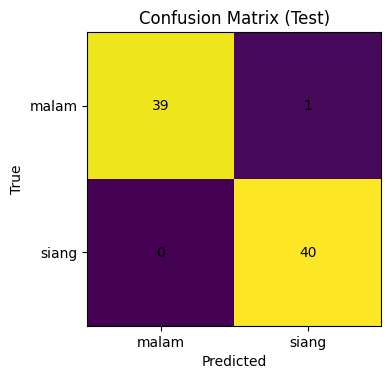

In [7]:
#@title Fit model terbaik & evaluasi pada test set
final_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=best_params["C"], gamma=best_params["gamma"]))
])
final_clf.fit(X_train, y_train)

y_pred = final_clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["malam", "siang"], output_dict=True)

print(f"Test Accuracy: {test_acc:.4f}")

# Simpan ringkasan ke CSV
summary_df = pd.DataFrame([{
    "n_samples": len(y),
    "n_train": len(y_train),
    "n_test": len(y_test),
    "feature_type": "HSV histogram (32 bins/channel)",
    "model": "SVM (RBF)",
    "tuning": "Optuna" if used_optuna else "RandomizedSearchCV",
    "cv_mean_accuracy": round(float(cv_best), 4),
    "test_accuracy": round(float(test_acc), 4),
    "best_C": best_params["C"],
    "best_gamma": best_params["gamma"]
}])
summary_path = "/content/svm_rbf_hist_results.csv"
summary_df.to_csv(summary_path, index=False)
print("Ringkasan disimpan ke:", summary_path)

# Simpan classification report
clsrep_df = pd.DataFrame(report).T
clsrep_path = "/content/classification_report.csv"
clsrep_df.to_csv(clsrep_path)
print("Classification report disimpan ke:", clsrep_path)

# Plot confusion matrix
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Test)")
plt.xticks([0,1], ["malam", "siang"])
plt.yticks([0,1], ["malam", "siang"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [ ]:
#@title Simpan pipeline model (joblib)
import joblib
model_path = "/content/svm_rbf_hist_pipeline.joblib"
joblib.dump(final_clf, model_path)
print("Model tersimpan:", model_path)
